# Carte annotée interactive de la Wikipedia en français

Nous allons créer ici une carte annotée de toutes les pages en français de Wikipedia.
Cette carte peut être explorée interactivement pour comprendre les relations de similitudes entre les pages telles que le comprend un modèle de langage.
Ce cahier de calcul démontre le processus entier,
faisant usage d'un ensemble de données public standard.

## Survol

Ce cahier se veut une démonstration de deux librairies, [Toponymy](https://github.com/TutteInstitute/toponymy/) et [DataMapPlot](https://datamapplot.readthedocs.io/en/latest/).
Toponymy est une librairie de modélisation de sujets d'avant-garde en développement actif.
Cet outil vise à générer un ensemble de sujets à résolutions multiples pour un grand corpus de documents,
produisant des annotations claires, concises et précises pour chaque sujet.
On utilise pour ce faire de nouvelles techniques de groupement,
une variété de méthodes d'extraction d'information
et des LLMs.
Toponymy est conçue autour d'approches flexibles et extensibles propres à résoudre des problèmes de modélisation de sujet généralisés,
tels que l'annotation d'images, de clips audio, et davantage.
Nous l'utilisons ici pour construire un ensemble hiérarchique détaillé de sujets pour Wikipedia en français.

DataMapPlot est une librairie de présentation de _cartes de données_, des index visuels basés sur des nuages de points bidimensionnels représentant des données de haute dimension.
Cet ensemble d'outils cherchent à automatiser les tâches compliquées de production de ce genre de graphique,
donnant l'opportunité à l'usager de se concentrer sur la dimension esthétique de l'expérience de visualisation plutôt que sur la mécanique de construction du graphique.
En particulier, DataMapPlot peut générer des visualisations interactives mues par des fichiers HTML,
permettant l'exploration de Wikipedia en zoomant de sujets de très haut niveau jusqu'aux sujets les plus fins et précis &mdash;
en plus de nombreuses autres interactions comme la recherche,
l'examen en survol (_tooltips_) et la réponse à la sélection de points.

L'objectif de ce cahier consiste à obtenir l'ensemble de données,
le modeler en une forme convenant à son annotation et sa visualisation,
puis laisser le travail le plus compliqué à Toponymy et DataMapPlot.
Nous utilisons ici les données fournies par Cohere,
qui ont pré-calculé les vecteurs de plongement (_embeddings_) de tous les paragraphes de Wikipedia
(à partir d'un instantané capturé en 2023).
Ceci nous épargne un énorme effort de calcul,
considérant comment les plongements peuvent être coûteux en calculs.
Nous allons ingéniérer ces données en informations relatives à chaque article de Wikipedia
(appelés _pages_ ci-après) et utiliser une technique de réduction  de dimensionnalité pour calculer une représentation visualisable.
Les données originales et leur représentation compressée sont passées à Toponymy pour produire les modèles de sujet hiérarchiques,
et DataMapPlot emballe le tout dans une interface de visualisation.

## Stockage des résultats intermédiaires

L'ensemble de données que nous utilisons ici est grand,
et l'accès via HuggingFace peut en être limité ou ralenti.
Par conséquent, nous traitons les fichiers séquentiellement,
et persistons les résultats intermédiaires.
Ainsi, si la chaîne de traitement est interrompue par un quelconque pépin,
on pourrait reprendre le travail sans recalculer ce qui a déjà été visité.
La cellule suivante désigne un répertoire sur votre ordinateur où ces résultats temporaires peuvent être placés.
Changez cet endroit à votre guise si le répertoire ci-fixé n'est pas adéquat.

In [1]:
from pathlib import Path
dir_cache = Path("work")

## Préparation des données

Nous prenons ici une approche relativement peu sophistiquée pour traiter les données.
Cette approche est principalement conditionnée par les restrictions d'accès aux données posées par HuggingFace,
dont la configuration refuse et brise les connexions HTTP trop fréquentes.
On se contente donc d'un traitement séquentiel:
chaque fichier composant l'ensemble de données est téléchargé puis traité tour-à-tour.
Ce processus robuste n'utilise pas forcément la pleine mesure des capacités de calcul de l'ordinateur typique,
mais il tend à ne pas causer autant d'interruptions ou d'erreurs d'accès.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import fsspec
import gc
import io
import numpy as np
import pandas as pd
import sklearn.metrics
import os
from pathlib import Path
from tqdm.auto import tqdm, trange

In [3]:
fs_hf = fsspec.filesystem("hf")
files_dataset = sorted(entry for entry in fs_hf.glob("datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/*.parquet"))
len(files_dataset)

179

In [4]:
dir_embeddings = dir_cache / "embeddings"
dir_embeddings.mkdir(parents=True, exist_ok=True)
dir_metadata = dir_cache / "metadata"
dir_metadata.mkdir(parents=True, exist_ok=True)

La principale difficulté posée par l'ensemble de données est que le découpage de la base de données en fichiers ne tient pas compte des articles.
En d'autres mots, certains articles ont certains paragraphes rapportés dans le fichier $n$, et leurs autres paragraphes stockés dans le fichier $n+1$.
Puisque les données sont stockées au format [Parquet](https://parquet.apache.org/docs/),
nous pouvons télécharger seulement le titre des articles associés à chaque paragraphe et identifier ces scissions des articles.
Ceci nous permettra de constituer un **index de l'ensemble de données** permettant la planification de la re-séparation des données en groupes de calcul qui rejoignent tous les paragraphes d'un sous-ensemble d'articles.
Cet index est un peu coûteux à constituer, alors nous le préservons parmi nos résultats intermédiaires.

In [5]:
titles_ = {}

In [6]:
path_index_dataset = dir_cache / "index.parquet"
if not path_index_dataset.is_file():
    while len(titles_) < len(files_dataset):
        try:
            for path in tqdm(files_dataset, desc="Indexing page titles"):
                if path not in titles_:
                    with fs_hf.open(path, "rb") as file:
                        titles_[path] = (
                            ParquetFile(file).read(columns=["title"]).to_pandas()
                            .groupby("title")
                            .agg({"title": "count"})
                            .rename(columns={"title": "num_records"})
                            .reset_index()
                            .assign(path=path)
                        )
        except requests.exceptions.HTTPError:
            delay = 90.
            print(f"HuggingFace is protesting our query rate: taking a {delay:.1f}-second pause")
            time.sleep(delay)
    pd.concat(titles_.values(), ignore_index=True).to_parquet(path_index_dataset, compression="zstd")

In [7]:
index_dataset = pd.read_parquet(path_index_dataset)
index_dataset

,title,num_records,path,batch
0,(145480) 2005 TB190,4,datasets/Cohere/wikipedia-2023-11-embed-multil...,0
1,(307616) 2003 QW90,1,datasets/Cohere/wikipedia-2023-11-embed-multil...,0
2,(35334) Yarkovsky,1,datasets/Cohere/wikipedia-2023-11-embed-multil...,0
3,(4328) Valina,1,datasets/Cohere/wikipedia-2023-11-embed-multil...,0
4,(4329) Miró,1,datasets/Cohere/wikipedia-2023-11-embed-multil...,0
...,...,...,...,...
2320266,Łączki-Pawłówek,1,datasets/Cohere/wikipedia-2023-11-embed-multil...,232
2320267,Łąkta,2,datasets/Cohere/wikipedia-2023-11-embed-multil...,232
2320268,Łęczyca (Lublin),1,datasets/Cohere/wikipedia-2023-11-embed-multil...,232
2320269,℟,2,datasets/Cohere/wikipedia-2023-11-embed-multil...,232


Nous découpons maintenant les données en groupes de calcul de 10 000 articles.
Chaque groupe sera constitué de façon à regrouper tous les paragraphes issus de ces 10 000 articles.

In [8]:
%%time
size_batch = 10000
if "batch" not in index_dataset.columns:
    index_dataset.sort_values(["title", "path"], inplace=True)
    titles_unique = index_dataset[["title"]].drop_duplicates().sort_index()
    batch = []
    n = 0
    while len(batch) < len(titles_unique):
        batch.extend([n] * size_batch)
        n += 1
    titles_unique["batch"] = batch[:len(titles_unique)]
    index_dataset = index_dataset.merge(titles_unique, how="inner", on="title").sort_values(["batch", "title"]).reset_index(drop=True)
    index_dataset.to_parquet(path_index_dataset, compression="zstd")
    display(index_dataset)

CPU times: user 18 μs, sys: 1e+03 ns, total: 19 μs
Wall time: 28.8 μs


In [9]:
path_embeddings_fr = dir_cache / "embeddings-fr.npy"
path_metadata_fr = dir_cache / "metadata-fr.parquet"

Pour chaque groupe de calcul, nous préservons deux fichiers intermédiaires:

1. Méta-données des articles
2. Vecteurs de plongement

Jetons un coup d'oeil aux premières pour déterminer quels groupes de calcul ont été traités jusqu'ici,
identifiant le travail qu'il reste à faire.

In [10]:
batches_done = {
    int(path.with_suffix("").name)
    for path in dir_metadata.glob("*.parquet")
}
index_todo = index_dataset.loc[~index_dataset["batch"].isin(batches_done)]
index_todo

,title,num_records,path,batch


In [11]:
index_todo["batch"].nunique()

0

Les deux prochaines routines téléchargent les données de l'ensemble pertinentes au travail qu'il nous reste à faire,
et constituent les groupes de calcul.

In [12]:
def load_file(path):
    with fs_hf.open(path, "rb") as file:
        return pd.read_parquet(file)

In [13]:
def iter_data_batches(index_todo):
    paths_gathered = set()
    records = pd.DataFrame(data=[], columns=["_id", "url", "title", "text", "emb"])
    for i_batch, batch in index_todo.groupby("batch"):
        # import pdb; pdb.set_trace()
        paths_batch = set(batch["path"])
        paths_needed = paths_batch - paths_gathered
        if paths_needed:
            records = pd.concat([records, *[load_file(path) for path in paths_needed]])
        paths_gathered |= paths_batch

        titles_batch = batch.groupby("title").agg({"num_records": "sum"})
        records_split = records.merge(titles_batch, how="left", on="title", indicator=True)
        records_batch = records_split.loc[records_split["_merge"] == "both"].drop(columns="_merge")
        assert (
            records_batch.groupby("title").agg({"emb": "count"})
            .rename(columns={"emb": "num_records"})
            .sort_values("title")
            .equals(
                titles_batch.sort_values("title")
            )
        )
        yield i_batch, records_batch

        records = records_split.loc[records_split["_merge"] == "left_only"].drop(columns=["num_records", "_merge"]).copy()
        gc.collect()

Et voici comment on traite les paragraphes de chaque article pour en extraire les méta-données.

In [14]:
def munge_article(article):
    embeddings_all = np.vstack(article["emb"])

    if len(article) < 2:
        topical_sentence = ""
    else:
        embeddings_tail = embeddings_all[1:]
        distances = sklearn.metrics.pairwise_distances([np.mean(embeddings_tail, axis=0)], embeddings_tail).squeeze()
        closest_idx = np.argmin(distances)
        topical_sentence = article["text"].iloc[1:].iloc[closest_idx]

    return pd.Series({
        "embeddings": np.mean(embeddings_all, axis=0),
        "lead_sentences": article["text"].iloc[0],
        "topical_sentences": topical_sentence,
        "word_counts": article["text"].str.split().map(len).sum()
    })

Nous avons tous les ingrédents:
allons-y, traitons les données.
Sur un MacBook Pro procuré en 2022,
le calcul entier prend environ 30 minutes.

In [15]:
for i_batch, batch in tqdm(iter_data_batches(index_todo), total=index_todo["batch"].nunique()):
    pages = (
        batch
        .groupby("title")
        .apply(munge_article)
        .reset_index()
        .rename(columns={"title": "titles"})
    )
    path_embeddings_batch = dir_embeddings / f"{i_batch:04d}.npy"
    path_metadata_batch = dir_metadata / f"{i_batch:04d}.parquet"
    try:
        np.save(path_embeddings_batch, np.vstack(pages["embeddings"]))
        pages[
            ["titles", "lead_sentences", "topical_sentences", "word_counts"]
        ].to_parquet(path_metadata_batch, compression="zstd")
    except:
        path_embeddings_batch.unlink(missing_ok=True)
        path_metadata_batch.unlink(missing_ok=True)

0it [00:00, ?it/s]

Nous pouvons maintenant assembler tous ces résultats intermédiaires deux fichiers unifiés pratiques.

In [16]:
if not all(p.exists() for p in [path_embeddings_fr, path_metadata_fr]):
    np.save(
        path_embeddings_fr,
        np.vstack([
            np.load(path)
            for path in tqdm(sorted(dir_embeddings.iterdir()), desc="Embeddings consolidation")
        ])
    )
    gc.collect()
    pd.concat(
        [pd.read_parquet(path) for path in tqdm(sorted(dir_metadata.iterdir()), desc="Metadata consolidation")],
        ignore_index=True
    ).to_parquet(path_metadata_fr, compression="zstd")
    gc.collect()

In [17]:
data_vectors = np.load(path_embeddings_fr)
metadata_fr = pd.read_parquet(path_metadata_fr)
metadata_fr

,titles,lead_sentences,topical_sentences,word_counts
0,(145480) 2005 TB190,", appelé provisoirement 2005 TB190, est un obj...",Des simulations d'orbite faites par Emel’yanen...,132
1,(307616) 2003 QW90,est un objet classique de la ceinture de Kuipe...,,23
2,(35334) Yarkovsky,(35334) Yarkovsky () est un astéroïde de la ce...,,20
3,(4328) Valina,(4328) Valina est un astéroïde de la ceinture ...,,19
4,(4329) Miró,(4329) Miró (pour Joan Miró) ou (4329) 1982 SX...,,34
...,...,...,...,...
2320115,Łączki-Pawłówek,Łączki-Pawłówek (prononciation : ) est un vill...,,28
2320116,Łąkta,Łąkta (prononciation : ) est un village polona...,Il se situe à environ au sud-est de Rawicz (s...,53
2320117,Łęczyca (Lublin),Łęczyca (prononciation : ) est un village polo...,,28
2320118,℟,Le caractère typographique ℟ sert à introduir...,"Lorsque l’on ne dispose pas de ces caractères,...",46


## Réduction de dimension

Nous avons besoin d'une représentation bidimensionnelle des vecteurs d'articles pour construire la carte.
Les membres de l'[Institut Tutte](https://github.com/TutteInstitute/), auteurs de ce travail, ont une [préférence méthodologique](https://github.com/lmcinnes/umap),
mais comme cette démonstration vise plutôt Toponymy et DataMapPlot, évitons de biaiser les résultats.
Nous utilisons donc [OpenTSNE](https://opentsne.readthedocs.io/en/stable/) pour réduire la dimension des données vectorielles tout en préservant leur structure de similarité locale.

In [18]:
import openTSNE
import datashader.mpl_ext
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [19]:
path_datamap = dir_cache / "wikipedia-fr-cohere-embed-datamap.npy"

<div class="alert alert-block alert-warning">
Le calcul de cette réduction de dimension est très coûteux en temps et en mémoire.
Un MacBook Pro 2022 muni de 32 GB de mémoire de travail arrive à compléter le calcul en <strong>6 heures et 15 minutes</strong>.
Il n'est pas exclus qu'un calculateur plus modeste arrive à terminer le calcul, moyennant une bonne dose de patience de la part de l'utilisateur.
Cependant, si vous n'avez pas accès aux ressources de calcul nécessaires,
transformez la cellule qui suit en cellule de code et exécutez-la pour télécharger les résultats ci-publiés.
</div>

In [20]:
%%time
path_datamap = dir_cache / "wikipedia-fr-cohere-embed-datamap.npy"
if not path_datamap.exists():
    data_map = openTSNE.TSNE(exaggeration=3., metric="cosine", n_jobs=os.cpu_count(), n_iter=4000, verbose=True).fit(data_vectors)
    np.save(path_datamap, data_map)

CPU times: user 90 μs, sys: 0 ns, total: 90 μs
Wall time: 90.1 μs


In [21]:
data_map = np.load(path_datamap)

Jetons un coup d'oeil pour s'assurer que ce résultat paraît raisonnable.

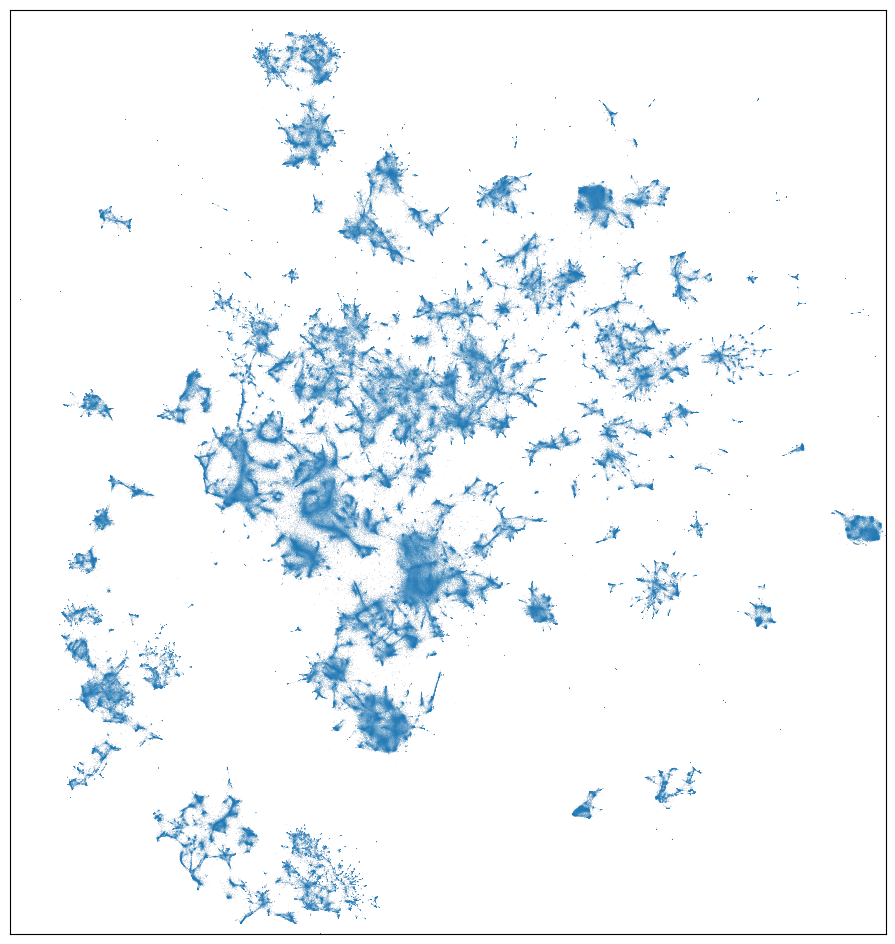

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
datashader.mpl_ext.dsshow(pd.DataFrame({"x":data_map[:, 0], "y":data_map[:, 1]}), datashader.Point('x', 'y'), aspect="equal", ax=ax, norm="eq_hist",
                          cmap=sns.color_palette("light:"+str([matplotlib.colors.rgb2hex(x) for x in sns.color_palette("tab10", 1)][0]), as_cmap=True))
_ = ax.set(xticks=[], yticks=[])

## Modélisation de sujets

Pour déterminer le sujet de divers groupes de documents, nous allons utiliser Toponymy.
On a besoin d'un peu du contenu textuel de chaque article:
créons-le en collant bout-à-bout le titre, la première phrase et une phrase topique pour chacun,
ces deux derniers raccourcis au besoin.
Nous gardons tous ces résumés dans le même ordre que notre ensemble d'articles.

In [23]:
%%time
def shorten(sentence):
    return (
        sentence[:2045] + "..."
        if len(sentence) >= 2048
        else sentence
    )

documents = (
    metadata_fr["titles"] + "\n\n"
    + metadata_fr["lead_sentences"].map(shorten)
    + "\n...\n"
    + metadata_fr["topical_sentences"].map(shorten)
    + "\n...\n"
)
documents

CPU times: user 2.28 s, sys: 1.31 s, total: 3.6 s
Wall time: 3.6 s


0          (145480) 2005 TB190\n\n, appelé provisoirement...
1          (307616) 2003 QW90\n\nest un objet classique d...
2          (35334) Yarkovsky\n\n(35334) Yarkovsky () est ...
3          (4328) Valina\n\n(4328) Valina est un astéroïd...
4          (4329) Miró\n\n(4329) Miró (pour Joan Miró) ou...
                                 ...                        
2320115    Łączki-Pawłówek\n\nŁączki-Pawłówek (prononciat...
2320116    Łąkta\n\nŁąkta (prononciation : ) est un villa...
2320117    Łęczyca (Lublin)\n\nŁęczyca (prononciation : )...
2320118    ℟\n\nLe caractère typographique ℟  sert à intr...
2320119    ℣\n\nLe caractère typographique ℣ est à lire «...
Length: 2320120, dtype: object

Pour utiliser Toponymy,
on doit pouvoir interroger un LLM et un modèle de plongement.
Nous avons la chance de pouvoir utiliser les modèles de Cohere via Azure AI Foundry.
Si vous répliquez ces résultats,
vous pouvez utiliser tout service ou modèle local qui vous plaît.
Toponymy peut interfacer avec les services d'IA générative de Cohere, OpenAI, Anthropic et AzureAI,
ainsi qu'avec les modèles locaux de `llama_cpp` et HuggingFace
(pour ces derniers, calculer contre un GPU adéquat est fortement conseillé).
Pour les plongements,
vous pouvez utiliser tout modèle supporté par [SentenceTransformers](https://sbert.net/)
(un GPU ici est également utile),
ou encore les services d'_embedding_ d'AzureAI, Cohere et ainsi de suite.

<div class="alert alert-block alert-info">
Toponymy offre par ailleurs des versions asynchrones expérimentales de la plupart des services d'IA supportés,
ce qui parallélise les requêtes de service,
permettant d'obtenir des résultats beaucoup plus rapidement
(sous condition des limites de taux de service).
Quiconque cherche à répliquer ces résultats est bienvenu d'utiliser ces versions `Async...`
des classes du module `llm_wrappers` et de nous rapporter quelque problème rencontré.
</div>

In [24]:
from toponymy import Toponymy, ToponymyClusterer, KeyphraseBuilder, ClusterLayerText
from toponymy.llm_wrappers import AsyncAzureAI, AzureAI
from toponymy.embedding_wrappers import AzureAIEmbedder

Insérez votre propre clef d'API ici...

In [24]:
%load_ext dotenv
%dotenv
from getpass import getpass
try:
    azure_api_key = os.environ["AZURE_COHERE_API_KEY"]
except KeyError:
    azure_api_key = getpass("Copy-paste your API key here:")
    Path(".env").write_text(f'AZURE_COHERE_API_KEY = "{azure_api_key}"\n', encoding="utf-8")
    print("It's saved to local file .env for future runs.")

Nous instantions ici l'interface au LLM et au modèle de plongement, ainsi qu'un groupeur et un constructeur de phrases-clef pour le traitement par Toponymy.
Insérez ici votre service ou modèle préféré;
vraisemblablement, le groupeur et le constructeur de phrase-clef n'ont besoin d'aucune modification.

In [25]:
llm = AsyncAzureAI(
    api_key=azure_api_key,
    endpoint="https://azureaitimcuse5821437469.services.ai.azure.com/models",
    model="Cohere-command-r-08-2024",
    llm_specific_instructions="Topic names should be in français not English",
)
embedding_model = AzureAIEmbedder(api_key=azure_api_key, endpoint="https://azureaitimcuse5821437469.services.ai.azure.com/models", model="Cohere-embed-v3-multilingual")
clusterer = ToponymyClusterer(min_clusters=8, base_n_clusters=16000, verbose=True)
keyphrase_builder = KeyphraseBuilder(verbose=True, n_jobs=16)

L'instance de la class Toponymy créée ici sera responsable de la modélisation des sujets.
Cet objet fournit une description des documents et du corpus, aidant à la génération de noms de sujet plus précis.
Dans notre cas, ceci est plutôt simple, puisque nous travaillons avec les documents textuels de Wikipedia.

In [26]:
topic_namer = Toponymy(
    llm,
    embedding_model,
    clusterer=clusterer,
    keyphrase_builder=keyphrase_builder,
    object_description='Wikipedia article title and excerpt',
    corpus_description='English language Wikipedia',
    show_progress_bars=True,
)

<div class="alert alert-block alert-danger">
La cellule qui suit démarre le processus de génération de noms de sujets.
Ce calcul va prendre plusieurs heures et utilisera les services d'IA configurés ci-haut,
entraînant la dépense d'un <strong>montant d'argent remarquable.</strong>
Les auteurs de ce travail ont complété une tâche de taille similaire en utilisant Claude-Haiku-3,
pour un coût d'environ 15$ (CAD),
mais les coûts actuels dépendent du service et du modèle sélectionnés.
En règle générale, les LLMs les moins chers de Anthropic, OpenAI et Cohere sont suffisamment performants pour livrer de bons résultats;
on obtient des résultats franchement similaires des modèles plus chers.
L'expérience courante suggère donc des rendements décroissants significatifs alors qu'on opte pour les modèles haut de gamme.
</div>

Assurons-nous de sauvegarder les résultats de façon à ne payer qu'une seule fois pour ces calculs dispendieux.

In [27]:
%%time
if all((dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy").is_file() for i in range(7)):
    print("Reading results from disk...")
    topic_layers = []
    for i in range(7):
        topic_layers.append(np.load(dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy", allow_pickle=True))
else:
    topic_namer.fit(documents, data_vectors, data_map, exemplar_method="central")

    for i, layer in enumerate(topic_namer.topic_name_vectors_):
        np.save(dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy", layer)
    topic_layers = topic_namer.topic_name_vectors_

Reading results from disk...
CPU times: user 274 ms, sys: 7.26 ms, total: 282 ms
Wall time: 281 ms


## Visualization de la carte de données

Enfin on arrive au but final: un index visuel du contenu entier de Wikipedia en français.
Pour ceci, on utilise DataMapPlot.
Le sous-module `selection_handlers` sera utile pour mettre en oeuvre une interaction permettant de caractériser des articles sélectionnés en comparaison au reste.

In [28]:
import datamapplot
import datamapplot.selection_handlers

Comme les gens de Cohere ont fait le plus gros de tout ce travail (plonger dans un espace vectoriel tout le texte de Wikipedia et fournir le tout dans un ensemble de données publiques, en plus des services dont nous nous sommes servis pour la modélisation des sujets), décorons nos visuels avec leur logo.

In [29]:
import requests
import PIL
cohere_logo_response = requests.get(
    "https://asset.brandfetch.io/idfDTLvPCK/idyv4d98RT.png",
    stream=True,
)
cohere_logo = np.asarray(PIL.Image.open(cohere_logo_response.raw))

Avant de se lancer dans une interface graphique interactive,
créons un visuel statique pour s'assurer qu'on tient quelque chose d'à peu près raisonnable.
Nous utilisons l'avant-dernière couche de sujets pour annoter ce graphique,
ce qui correspond à un niveau de détails un degré plus fin que le niveau le plus grossier.
En effet, dans un graphique statique, on doit garder les descriptions à un niveau encore élevé,
de peur que des descriptions plus nombreuses et détaillées encombrent le visuel.
Juste parce que nous le _pouvons_, prenons la peine d'ajouter un peu de flair stylistique à ce graphique:
nous allons courber joliment les flèches d'association de la carte aux sujets,
rédiger le texte dans une police de caractères soignée
et choisir une couleur d'arrière-plan qui capture l'attention.

Calculating medoids: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


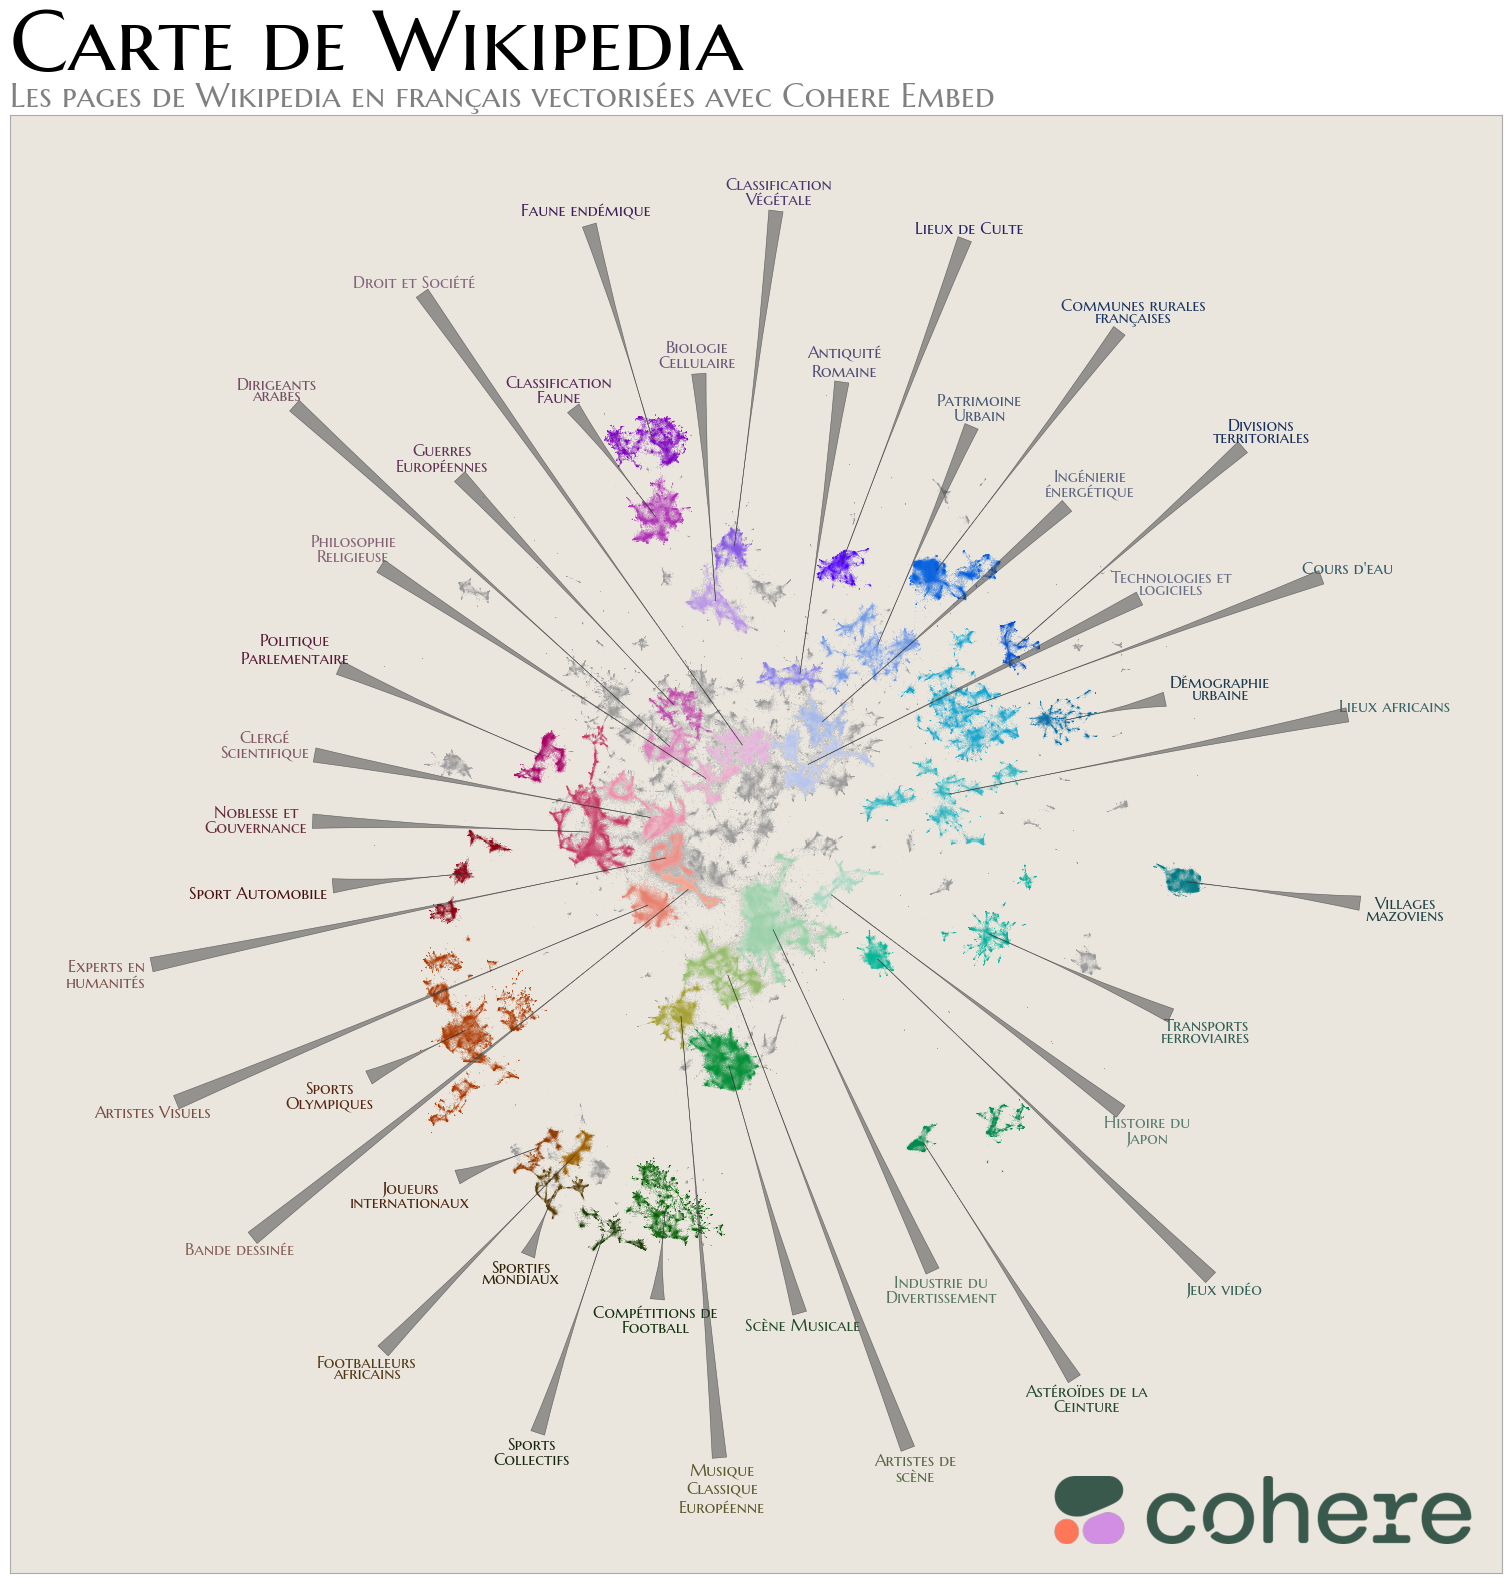

In [30]:
fig, ax = datamapplot.create_plot(
    data_map.astype(np.float32),
    topic_layers[5],
    title="Carte de Wikipedia",
    sub_title="Les pages de Wikipedia en français vectorisées avec Cohere Embed",
    logo=cohere_logo,
    logo_width=0.28,
    use_medoids=True,
    arrowprops={"arrowstyle": "wedge,tail_width=0.85,shrink_factor=0.15", "linewidth": 0.4, "fc": "#33333377", "ec": "#333333aa"},
    font_family="Marcellus SC",
    label_linespacing=1.25,
    label_direction_bias=1.25,
    title_keywords={"fontsize":61.5},
    figsize=(15,15)
)
_ = ax.set(facecolor="#eae6de")

Très bien, maintenant nous désirons construire une interface d'exploration interactive.
C'est aussi simple, à la base, que d'invoquer `datamapplot.create_interactive_plot`.
Cependant, nous voulons augmenter l'expérience de base.

### Résumé des articles survolés

Si le pointeur de souris survole un point, on veut attraper le résumé de l'article correspondant au vol et le montrer dans un encart ad hoc.
Si on pouvait se permettre de télécharger en mémoire tout le contenu de Wikipedia, on pourrait préparer ces _tooltips_ d'avance.
À défaut, on doit interroger les services programmables de Wikipedia (API) pour obtenir ces résumés à mesure des survols.
Pour cela, nous donnons à DataMapPlot les routines Javascript qui interrogent ces services et formattent les résultats dans de tels encarts.

In [31]:
api_tooltip = {
    "fetch_js": """
async (identifier) => {
    const apiUrl = `https://fr.wikipedia.org/w/api.php?` +
      `action=query&` +
      `format=json&` +
      `prop=extracts|pageimages&` +
      `exintro=1&` +
      `explaintext=1&` +
      `pithumbsize=300&` +
      `titles=${encodeURIComponent(identifier)}&` +
      `origin=*`;

    const response = await fetch(apiUrl);
    const json = await response.json();
    const page = Object.values(json.query.pages)[0];

    const content = {
      title: page.title,
      extract: page.extract,
      thumbnail: page.thumbnail?.source,
      url: `https://fr.wikipedia.org/wiki/${encodeURIComponent(page.title)}`
    };
    return content;
}
    """,
    "format_js": """
(data) => {
    return `
      <h3 style="margin: 0 0 8px 0">${data.title}</h3>
      ${data.thumbnail ?
        `<img src="${data.thumbnail}"
          style="float: right; max-width: 100px; margin: 0 0 8px 8px;"
          alt="${data.title}"/>`
        : ''}
      <p style="margin: 0; line-height: 1.4;">
        ${data.extract.split('. ').slice(0, 3).join('. ')}.
      </p>
    `;
}
    """,
    "loading_js": """
(identifier) => {
    return `
      <h3 style="margin: 0 0 8px 0">${identifier}</h3>
      Chargement ...
      `
}
    """,
    "error_js": """
(error, identifier) => `Erreur durant le chargement de l'information sur ${identifier}: ${error.message}`
    """,
}

### Nuages des mots sur sélection

La sélection d'un groupe de points manifeste une question de l'usager: _qu'est-ce que ces articles ont en commun?_
Une approche conventionnelle pour répondre à cette question est la construction d'un [nuage de mots](https://fr.wikipedia.org/wiki/Nuage_de_mots-cl%C3%A9s).
Pour la même raison qu'il est intractable de préparer à l'avance les _tooltips_ pour chacun des points du graphique,
nous devons adapter ici le constructeur de nuages de mots stock de DataMapPlot pour obtenir dynamiquement les résumés des articles sélectionnés.
C'est un changement mineur du code existant pour la classe [`datamapplot.selection_handlers.WordCloud`](https://github.com/TutteInstitute/datamapplot/blob/d91569190a9e9368dadeebec7c1ebab0e234ee49/datamapplot/selection_handlers.py#L235),
alors nous la ramenons ici et procédons à la chirurgie sous anesthésie locale toute simple.

In [32]:
from datamapplot.selection_handlers import SelectionHandlerBase
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

from datamapplot.config import ConfigManager
cfg = ConfigManager()

class WikipediaWordCloud(SelectionHandlerBase):
    """A selection handler that generates a word cloud from the selected text items by pulling the
    relevant text from Wikipedia pages with the titles given by the selection. The word cloud
    is displayed in a container on the page, and the number of words in the cloud can be controlled
    by the `n_words` parameter.

    The word cloud is generated using the d3-cloud library, and the appearance of the word cloud can
    be customized using the `width`, `height`, `font_family`, `stop_words`, `n_rotations`, and `color_scale`
    parameters.

    Parameters
    ----------
    n_words : int, optional
        The number of words to display in the word cloud. Default is 256.

    width : int, optional
        The width of the word cloud container. Default is 500.

    height : int, optional
        The height of the word cloud container. Default is 500.

    font_family : str, optional
        The font family to use for the word cloud. Default is None.

    stop_words : list, optional
        A list of stop words to exclude from the word cloud. Default is the English stop words from scikit-learn.

    n_rotations : int, optional
        The number of rotations to use for the words in the word cloud. Default is 0. More rotations can make the
        word cloud more visually interesting, at the cost of readability.

    color_scale : str, optional
        The color scale to use for the word cloud. Default is "YlGnBu". The color scale can be any d3 color scale
        name, with an optional "_r" suffix to reverse the color scale.

    location : str, optional
        The location of the word cloud container on the page. Default is "bottom-right".
        Should be one of "top-left", "top-right", "bottom-left", or "bottom-right".

    **kwargs
        Additional keyword arguments to pass to the SelectionHandlerBase constructor.

    """

    @cfg.complete(unconfigurable={"self", "width", "height", "n_words"})
    def __init__(
        self,
        n_words=256,
        width=500,
        height=500,
        font_family=None,
        stop_words=None,
        n_rotations=0,
        use_idf=False,
        color_scale="YlGnBu",
        location="bottom-right",
        cdn_url="unpkg.com",
        other_triggers=None,
        **kwargs,
    ):
        super().__init__(
            dependencies=[
                f"https://{cdn_url}/d3@latest/dist/d3.min.js",
                f"https://{cdn_url}/d3-cloud@1.2.7/build/d3.layout.cloud.js",
                f"https://{cdn_url}/jquery@3.7.1/dist/jquery.min.js",
            ],
            **kwargs,
        )
        self.n_words = n_words
        self.width = width
        self.height = height
        self.font_family = font_family
        self.stop_words = stop_words or list(ENGLISH_STOP_WORDS)
        self.n_rotations = min(22, n_rotations)
        self.use_idf = str(use_idf).lower()
        self.location = location
        if color_scale.endswith("_r"):
            self.color_scale = string.capwords(color_scale[:1]) + color_scale[1:-2]
            self.color_scale_reversed = True
        else:
            self.color_scale = string.capwords(color_scale[:1]) + color_scale[1:]
            self.color_scale_reversed = False
        self.other_triggers = other_triggers

    @property
    def javascript(self):
        result = f"""
const _STOPWORDS = new Set({self.stop_words});
const _ROTATIONS = [0, -90, 90, -45, 45, -30, 30, -60, 60, -15, 15, -75, 75, -7.5, 7.5, -22.5, 22.5, -52.5, 52.5, -37.5, 37.5, -67.5, 67.5];
let wordCloudStackContainer = document.getElementsByClassName("stack {self.location}")[0];
const wordCloudItem = document.createElement("div");
wordCloudItem.id = "word-cloud";
wordCloudItem.className = "container-box more-opaque stack-box";
wordCloudStackContainer.appendChild(wordCloudItem);

const wordCloudSvg = d3.select("#word-cloud").append("svg")
    .attr("width", {self.width})
    .attr("height", {self.height})
    .append("g")
    .attr("transform", "translate(" + {self.width} / 2 + "," + {self.height} / 2 + ")");

var wordCounter = null;
wordCounter = function (textItems) {{
    const words = textItems.join(' ').toLowerCase().split(/\\s+/);
    const wordCounts = new Map();
    words.forEach(word => {{
        wordCounts.set(word, (wordCounts.get(word) || 0) + 1);
    }});
    _STOPWORDS.forEach(stopword => wordCounts.delete(stopword));
    const result = Array.from(wordCounts, ([word, frequency]) => ({{ text: word, size: Math.sqrt(frequency) }}))
                        .sort((a, b) => b.size - a.size).slice(0, {self.n_words});
    const maxSize = Math.max(...(result.map(x => x.size)));
    return result.map(({{text, size}}) => ({{ text: text, size: (size / maxSize)}}));
}}

// Cache for API responses
const batchCache = new Map();

async function fetchWikiContentBatch(titles, maxTitles = 250) {{
    // Deduplicate and filter already cached titles
    const uniqueTitles = [...new Set(titles)];
    const titlesToFetch = uniqueTitles.filter(title => !batchCache.has(title));

    // Split titles into chunks of 50 (API limit per request)
    const chunks = [];
    for (let i = 0; i < Math.min(titlesToFetch.length, maxTitles); i += 50) {{
        chunks.push(titlesToFetch.slice(i, i + 50));
    }}

    // Process each chunk
    const results = [];

    try {{
        // Fetch all chunks in parallel
        await Promise.all(chunks.map(async (titleChunk) => {{
            const titleString = titleChunk.join('|');
            const apiUrl = `https://fr.wikipedia.org/w/api.php?` +
                `action=query&` +
                `format=json&` +
                `prop=extracts&` +
                `exintro=0&` + // Get full content, not just intro
                `explaintext=1&` +
                `titles=${{encodeURIComponent(titleString)}}&` +
                `origin=*`;

            const response = await fetch(apiUrl);
            const json = await response.json();

            // Process each page in the response
            Object.values(json.query.pages).forEach(page => {{
                // Store in both results and cache
                if (page.extract) {{
                  results.push(page.extract);
                  batchCache.set(page.title, page.extract);
                }} else {{
                  results.push(page.title);
                }}
            }});
        }}));

        // Combine cached and new results
        return results.concat(Array.from(uniqueTitles).filter(title => batchCache.has(title)).map(title => batchCache.get(title)));

    }} catch (error) {{
        console.error('Error fetching Wikipedia content batch:', error);
        return new Map();
    }}
}}

function generateWordCloud(words) {{
  const width = {self.width};
  const height = {self.height};

  const colorScale = d3.scaleSequential(d3.interpolate{self.color_scale}).domain([{"width / 10, 0" if self.color_scale_reversed else "0, width / 10"}]);

  // Configure a cloud layout
  const layout = d3.layout.cloud()
    .size([width, height])
    .words(words.map(d => ({{text: d.text, size: d.size * width / 10}})))
    .padding(1)
    .rotate(() => _ROTATIONS[~~(Math.random() * {self.n_rotations})])
    .font("{self.font_family or 'Impact'}")
    .fontSize(d => d.size)
    .fontWeight(d => Math.max(300, Math.min(d.size * 9000 / width, 900)))
    .on("end", draw);

  layout.start();

  function draw(words) {{
    const t = d3.transition().duration(300);

    // Update existing words
    const text = wordCloudSvg.selectAll("text")
      .data(words, d => d.text);

    // Remove old words
    text.exit()
      .transition(t)
      .attr("fill-opacity", 0)
      .attr("font-size", 1)
      .remove();
    // Add new words
    text.enter()
      .append("text")
      .attr("text-anchor", "middle")
      .attr("fill-opacity", 0)
      .attr("font-size", 1)
      .attr("font-family", "{self.font_family or 'Impact'}")
      .text(d => d.text)
      .merge(text) // Merge enter and update selections
      .transition(t)
      .attr("transform", d => "translate(" + [d.x, d.y] + ")rotate(" + d.rotate + ")")
      .attr("fill-opacity", 1)
      .attr("font-size", d => d.size)
      .attr("font-weight", d => Math.max(300, Math.min(d.size * 9000 / width, 900)))
      .attr("fill", d => colorScale(d.size));
  }}
}}

const shuffle = ([...arr]) => {{
  let m = arr.length;
  while (m) {{
    const i = Math.floor(Math.random() * m--);
    [arr[m], arr[i]] = [arr[i], arr[m]];
  }}
  return arr;
}};
const sampleSize = ([...arr], n = 1) => shuffle(arr).slice(0, n);

async function wordCloudCallback(selectedPoints) {{
    if (selectedPoints.length > 0) {{
        $(wordCloudItem).animate({{height:'show'}}, 250);
    }} else {{
        $(wordCloudItem).animate({{height:'hide'}}, 250);
    }}
    let selectedText;
    if (datamap.metaData) {{
        selectedText = await fetchWikiContentBatch(sampleSize(selectedPoints, 500).map(i => datamap.metaData.hover_text[i]));
    }} else {{
        selectedText = ["Le chargement des métadonnées est en cours..."];
    }}
    const wordCounts = wordCounter(selectedText);
    generateWordCloud(wordCounts);
}}

await datamap.addSelectionHandler(debounce(wordCloudCallback));
"""
        if self.other_triggers:
            for trigger in self.other_triggers:
                result += f"""await datamap.addSelectionHandler(debounce(wordCloudCallback), "{trigger}");\n"""
        return result

    @property
    def html(self):
        # return """<div id="word-cloud" class="container-box more-opaque"></div>"""
        return ""

    @property
    def css(self):
        return f"""
#word-cloud {{
    position: relative;
    display: none;
    width: {self.width}px;
    height: {self.height}px;
    z-index: 10;
}}
"""

La construction des nuages de mots nécessite l'exclusion des [mots vides](https://fr.wikipedia.org/wiki/Mot_vide) présents dans les textes.
Le module [Python Stop Words](https://github.com/Alir3z4/python-stop-words) fournit des listes de mots vides pour deux douzaines de langages européens et asiatiques,
dont le français.

In [33]:
from stop_words import get_stop_words
STOP_WORDS_FR = get_stop_words("fr")
pd.Series(STOP_WORDS_FR)

0           a
1          ai
2         aie
3       aient
4        aies
        ...  
242    étions
243       été
244      étés
245      êtes
246      être
Length: 247, dtype: object

### À-propos

Il serait agréable d'avoir un bouton qu'un usager peut cliquer pour faire apparaître une boîte donnant diverses informations sur la carte, sa création et son usage.
Ce n'est pas une fonctionnalité fournie directement par DataMapPlot,
mais nous pouvons ajouter le CSS et le Javascript de notre crû.

In [34]:
custom_css = """
#info-box {
    width: fit-content;
    height: fit-content;
    z-index: 10;
    overflow: hidden;
    width: 20px;
    height: 20px;
    display: flex;
    align-items: center;
    justify-content: center;
}

#info-icon {
    display: flex;
    align-items: center;
    justify-content: center;
    width: 100%;
    height: 100%;
}

#info-icon svg {
    width: 16px;
    height: 16px;
}

#info-content {
    display: none;
    position: absolute;
    padding: 12px;
    box-sizing: border-box;
    width: 100%;
    height: 100%;
    overflow-y: auto;
    pointer-events: none;
}

#info-content h3 {
    margin-top: 0;
    margin-bottom: 10px;
    color: #0056b3;
    font-size: 1.1em;
}

#info-content p {
    margin-bottom: 0;
    font-size: 0.9em;
    line-height: 1.2;
}

#info-box.expanded {
    width: 600px;
    height: auto;
    min-height: 100px;
    max-height: 800px;
    border: 1px solid #ccc;
    align-items: flex-start;
    justify-content: flex-start;
    overflow-y: auto;
}

#info-box.expanded #info-icon {
    pointer-events: none;
    display: none;
}

#info-box.expanded #info-content {
    position: relative;
    display: block;
    pointer-events: auto;
}
"""

custom_js = """
const infoWidget = document.createElement("div");
infoWidget.id = "info-box";
infoWidget.className = "container-box more-opaque stack-box";
infoWidget.innerHTML = `
<div id="info-icon">
  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 16 16" fill="currentColor">
    <path d="M8 15A7 7 0 1 1 8 1a7 7 0 0 1 0 14zm0 1A8 8 0 1 0 8 0a8 8 0 0 0 0 16z"/>
    <path d="m8.93 6.588-2.29.287-.082.38.45.083c.294.07.352.176.288.469l-.738 3.468c-.194.897.105 1.319.808 1.319.545 0 1.178-.252 1.465-.598l.088-.416c-.2.176-.492.246-.686.246-.275 0-.375-.193-.304-.533L8.93 6.588zM9 4.5a1 1 0 1 1-2 0 1 1 0 0 1 2 0z"/>
  </svg>
</div>
<div id="info-content">
    <h3>À propos de cette <em>carte de données</em></h3>
    <p>
        Cette page constitue une carte explorable de Wikipedia en français.
        Elle a été constuite en utilisant des
        <a href="https://huggingface.co/datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3">plongements
        compilés par Cohere</a>, openTSNE, <a href="https://github.com/TutteInstitute/toponymy">Toponymy</a>,
        ainsi que <a href="https://github.com/TutteInstitute/datamapplot">DataMapPlot</a>.
        Elle existe en tant que vitrine pour certaines des fonctionnalités
        des librairies DataMapPlot et Toponymy.
    </p>
    <p>
        Les étiquettes des sujets ont été générées automatiquement en utilisant
        Toponymy et le LLM Cohere Command-R.
    </p>
    <p>
        Cliquez et glissez pour déplacer la carte, utilisez la roulette de souris ou pincez l'écran pour zoomer.
        Cliquer sur un point naviguera à la page correspondante.<br/>
        L'arbre des sujets (<em>topic tree</em>) facilite le déplacement vers des sujets spécifiques.
        Développez les sujets en cliquant sur le triangle pour révéler des sous-sujets plus précis.
        Cliquez sur le nom d'un sujet pour centrer la vue de la carte sur sa position.<br/>
        En tenant Shift, cliquez et glissez pour sélectionner une région:
        cela générera un <em>nuage de mots</em> à partir du contenu des pages sélectionnées.
        Sélectionnez une région vide pour faire disparaître l'encart du nuage.
    </p>
</div>
`
const stackContainer = document.getElementsByClassName("stack bottom-left")[0];
stackContainer.insertBefore(infoWidget, stackContainer.firstChild);
if (infoWidget) {
    infoWidget.addEventListener('click', function() {
        infoWidget.classList.toggle('expanded');
    });
} else {
    console.error("On ne trouve pas l'élément avec ID 'info-widget'.");
}
"""

### Méta-données sur les articles

Finalement, en plus du nombre de mots de chaque article qu'on tient déjà en main,
il serait bien d'avoir d'autres méta-données sur les articles qu'on pourrait montrer par chromographie.
[Leland McInnes](https://github.com/lmcinnes/) a capturé,
pour les pages listées dans l'ensemble de données,
le nombre de liens entrants, le nombre de liens sortants,
le nombre de catégories auxquelles l'article appartient
et le nombre de visites de l'article dans le dernier mois.
Bien qu'il soit relativement simple de recueillir cette information en utilisant les services programmables de Wikipedia,
c'est une tâche fastidieuse.
Leland a donc sauvegardé ses données et les a partagées via HuggingFace.

In [35]:
wikipedia_page_stats = pd.read_parquet("hf://datasets/lmcinnes/wikipedia_page_statistics/wikipedia_page_stats.parquet")

### L'interface interactive, enfin!

Tous les ingrédients sont en place pour construire l'interface.
En plus des fonctionnalités que nous avons préparées ci-haut,
la construction consomme la représentation 2D des vecteurs d'article
et la liste de couches de noms de sujets produite par Toponymy.
Pour rendre la carte encore plus intéressante, nous ajoutons:

1. une fonctionnalité de recherche (parmi les titres d'articles);
2. une réaction telle qu'en cliquant sur un point, le navigateur ouvre un onglet vers la page Wikipedia correspondante;
3. un sélecteur permettant de colorer les points au gré du nombre de liens entrants, du nombre de catégories ou du nombre de visites;
4. une _table des matières_ hiérarchique permettant la navigation via l'arbre de sujets généré par Toponymy;
5. un avertissement d'ouverture, puisqu'il faut un moment pour télécharger toutes les données nécessaires à l'expérience interactive.

Comme notre ensemble de données est grand et qu'il y a beaucoup à assembler, la cellule qui suit rumine pendant un bon moment (une dizaine de minutes sur un MacBook Pro 2022).
C'est un moment bien choisi pour faire quelques étirements et boire un peu d'eau.

In [36]:
%%time
wikipedia_plot_bundle = datamapplot.create_interactive_plot(
    data_map,
    *topic_layers,
    hover_text=metadata_fr.titles.values,
    cluster_boundary_polygons=True,
    polygon_alpha=0.1,
    cluster_boundary_line_width=0.2,
    enable_search=True,
    point_radius_min_pixels=0.2,
    point_radius_max_pixels=16,
    point_line_width=0,
    marker_size_array=np.sqrt(metadata_fr.word_counts.values),
    initial_zoom_fraction=0.9,
    font_family="Cinzel",
    title="Carte interactive de Wikipedia",
    sub_title="Une carte des articles en français de Wikipedia. Les articles similaires correspondent à des points rapprochés.",
    logo="https://asset.brandfetch.io/idfDTLvPCK/idyv4d98RT.png",
    on_click="window.open(`https://fr.wikipedia.org/wiki/${{encodeURIComponent(hoverData.hover_text[index])}}`)",
    selection_handler=WikipediaWordCloud(512, width=640, height=480, font_family="Cinzel", stop_words=STOP_WORDS_FR, n_rotations=1, location="top-right"),
    colormap_rawdata=[
        np.log10(1 + wikipedia_page_stats.incoming_link_count),
        np.log10(1 + wikipedia_page_stats.category_count),
        np.log10(1 + wikipedia_page_stats.page_view_count)
    ],
    colormap_metadata=[
        {"field": "inlinks", "description": "Log du nombre de liens antécédents", "cmap": "mako_r", "kind": "continuous"},
        {"field": "categories", "description": "Log du nombre de catégories", "cmap": "rocket_r", "kind": "continuous"},
        {"field": "views", "description": "Log du nombre de visites par mois", "cmap": "YlGn", "kind": "continuous"},
    ],
    enable_topic_tree=True,
    topic_tree_kwds={"color_bullets": True},
    splash_warning="<p>Cette page va télécharger environ 200MB de données pour construire une carte interactive de Wikipedia.</p><p>Ce chargement initial peut prendre un bon moment...</p>",
    inline_data=False,
    offline_data_chunk_size=400_000,
    dynamic_tooltip=api_tooltip,
    custom_js=custom_js,
    custom_css=custom_css,
)

CPU times: user 11min 20s, sys: 15.6 s, total: 11min 36s
Wall time: 9min 57s


L'objet `wikipedia_plot_bundle` ci-haut met en oeuvre une application web trop volumineuse pour être rendue à travers ce cahier de calcul.
On peut cependant sauvegarder l'application par la méthode `save_bundle`,
qui place toutes les composantes documentaires dans un fichier Zip.
Ce fichier peut être décompressé sur un serveur web;
si cela est fait dans un répertoire local, on peut lancer un serveur web rapidement avec `python -m http.server -b 127.0.0.1 8080`, par exemple.

In [37]:
wikipedia_plot_bundle.save_bundle('wikipedia_fr_data_map.zip')

Adding datamapplot_point_data_0.zip to bundle
Adding datamapplot_point_data_1.zip to bundle
Adding datamapplot_point_data_2.zip to bundle
Adding datamapplot_point_data_3.zip to bundle
Adding datamapplot_point_data_4.zip to bundle
Adding datamapplot_point_data_5.zip to bundle
Adding datamapplot_meta_data_0.zip to bundle
Adding datamapplot_meta_data_1.zip to bundle
Adding datamapplot_meta_data_2.zip to bundle
Adding datamapplot_meta_data_3.zip to bundle
Adding datamapplot_meta_data_4.zip to bundle
Adding datamapplot_meta_data_5.zip to bundle
Adding datamapplot_label_data.zip to bundle
Adding datamapplot_color_data_0.zip to bundle
Adding datamapplot_color_data_1.zip to bundle
Adding datamapplot_color_data_2.zip to bundle
Adding datamapplot_color_data_3.zip to bundle
Adding datamapplot_color_data_4.zip to bundle
Adding datamapplot_color_data_5.zip to bundle


Alternativement, toutes ces données peuvent être entassées dans un fichier HTML monstrueux qui peut être ouvert localement.
Pour produire ce fichier, commentez les lignes

```python
    inline_data=False,
    offline_data_chunk_size=400_000,
```

dans la cellule de production de l'interface interactive, et exécutez cette cellule à nouveau.
Puis, transformez la cellule suivante en cellule de code et exécutez.

<div class="alert alert-block alert-success">
Une carte de données construite en exécutant ce cahier peut être <a href="https://datamapplot.org/datamapplot_examples/wikipedia-fr/"><strong>consultée ici</strong></a>.
</div>